# BirdCLEF 2023 - EDA
The goal here is to apply the guidelines and approach presented in the [First Steps, Road to the Top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series of notebooks. Following that series, we'll look to use FastAI/PyTorch to create an effective validation set and iterate rapidly!

To overall plan is to start with transfer learning to train CNNs on spectrograms.

This notebook focuses on exploratory data analysis. The analysis guides conversion of audio to spectrograms and identifies avenues to explore to improve performance later.

# Setup

## Download competition data and install packages
Prerequisites if running off of Kaggle:
1. Create a python environment
2. [Create `~/.kaggle/kaggle.json`](https://www.kaggle.com/docs/api)
3. [Join the competition](https://www.kaggle.com/competitions/birdclef-2023)

In [3]:
from fastkaggle import setup_comp

comp  = 'birdclef-2023'
comp_path = setup_comp(comp, install='fastai timm fastaudio')
comp_path.ls()

(#11) [Path('birdclef-2023/train_audio_prep-2'),Path('birdclef-2023/eBird_Taxonomy_v2021.csv'),Path('birdclef-2023/test_soundscapes'),Path('birdclef-2023/train_metadata.csv'),Path('birdclef-2023/train_audio_prep-2b'),Path('birdclef-2023/train_audio_prep-20-60s-32k'),Path('birdclef-2023/train_audio'),Path('birdclef-2023/sample_submission.csv'),Path('birdclef-2023/train_audio_prep'),Path('birdclef-2023/train_audio_prep-30s-32k')...]

## Load packages

In [4]:
from fastai.vision.all import *
import pandas as pd
import itertools
import torch
import torchaudio
import IPython.display
import mimetypes
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold
from fastaudio.core.all import *
from fastaudio.augment.all import *

print(torch.__version__, torchaudio.__version__)

2.0.0+cu117 2.0.1+cu117


# EDA

In [5]:
trn_path = comp_path/'train_audio'
trn_path.ls()

(#264) [Path('birdclef-2023/train_audio/somgre1'),Path('birdclef-2023/train_audio/whcpri2'),Path('birdclef-2023/train_audio/egygoo'),Path('birdclef-2023/train_audio/woosan'),Path('birdclef-2023/train_audio/yebapa1'),Path('birdclef-2023/train_audio/hamerk1'),Path('birdclef-2023/train_audio/hartur1'),Path('birdclef-2023/train_audio/rebfir2'),Path('birdclef-2023/train_audio/strher'),Path('birdclef-2023/train_audio/wtbeat1')...]

## Confirm data
Expect 16941 `.ogg` files and no other training files

In [6]:
ogg_files = get_files(trn_path, extensions='.ogg')
assert len(ogg_files) == 16941, 'Do not have expected number of training ogg files'
ogg_files

(#16941) [Path('birdclef-2023/train_audio/somgre1/XC446893.ogg'),Path('birdclef-2023/train_audio/somgre1/XC633806.ogg'),Path('birdclef-2023/train_audio/somgre1/XC655042.ogg'),Path('birdclef-2023/train_audio/somgre1/XC412153.ogg'),Path('birdclef-2023/train_audio/somgre1/XC411731.ogg'),Path('birdclef-2023/train_audio/somgre1/XC459432.ogg'),Path('birdclef-2023/train_audio/somgre1/XC728971.ogg'),Path('birdclef-2023/train_audio/somgre1/XC600782.ogg'),Path('birdclef-2023/train_audio/somgre1/XC607223.ogg'),Path('birdclef-2023/train_audio/somgre1/XC718280.ogg')...]

In [7]:
num_other_files = len(get_files(trn_path)) - len(ogg_files)
assert num_other_files == 0, 'Found non-ogg training files!'

In [8]:
IPython.display.Audio(filename=ogg_files[0])

## Load Sample Submission

In [9]:
sample_sub_df = pd.read_csv(comp_path/'sample_submission.csv')
sample_sub_df.head()

,row_id,abethr1,abhori1,abythr1,afbfly1,afdfly1,afecuc1,affeag1,afgfly1,afghor1,...,yebsto1,yeccan1,yefcan,yelbis1,yenspu1,yertin1,yesbar1,yespet1,yetgre1,yewgre1
0,soundscape_29201_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,soundscape_29201_10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,soundscape_29201_15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load & Explore Provided Metadata

In [10]:
trn_df = pd.read_csv(comp_path/'train_metadata.csv')
lst_cols = ['secondary_labels', 'type']
for col in lst_cols:
    # trn_df[col] = trn_df[col].apply(lambda x: x[1:-1].split(','))
    trn_df[col] = trn_df[col].apply(eval)
    
assert len(trn_df) == len(ogg_files), 'Number of ogg files does not match number of rows in the training metadata'
trn_df.head().T

,0,1,2,3,4
primary_label,abethr1,abethr1,abethr1,abethr1,abethr1
secondary_labels,[],[],[],[],[]
type,[song],[call],[song],[song],"[call, song]"
latitude,4.3906,-2.9524,-2.9524,-2.9524,-2.9524
longitude,38.2788,38.2921,38.2921,38.2921,38.2921
scientific_name,Turdus tephronotus,Turdus tephronotus,Turdus tephronotus,Turdus tephronotus,Turdus tephronotus
common_name,African Bare-eyed Thrush,African Bare-eyed Thrush,African Bare-eyed Thrush,African Bare-eyed Thrush,African Bare-eyed Thrush
author,Rolf A. de By,James Bradley,James Bradley,James Bradley,James Bradley
license,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0
rating,4.0,3.5,3.5,5.0,4.5


In [11]:
type(trn_df.type[0])

list

In [12]:
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

### Primary Label

There should be 264 primary labels.

In [13]:
assert len(trn_df.primary_label.unique()) == 264, 'Did not find the expected number of primary labels'

In [14]:
L(list(trn_df.primary_label.unique()))

(#264) ['abethr1','abhori1','abythr1','afbfly1','afdfly1','afecuc1','affeag1','afgfly1','afghor1','afmdov1'...]

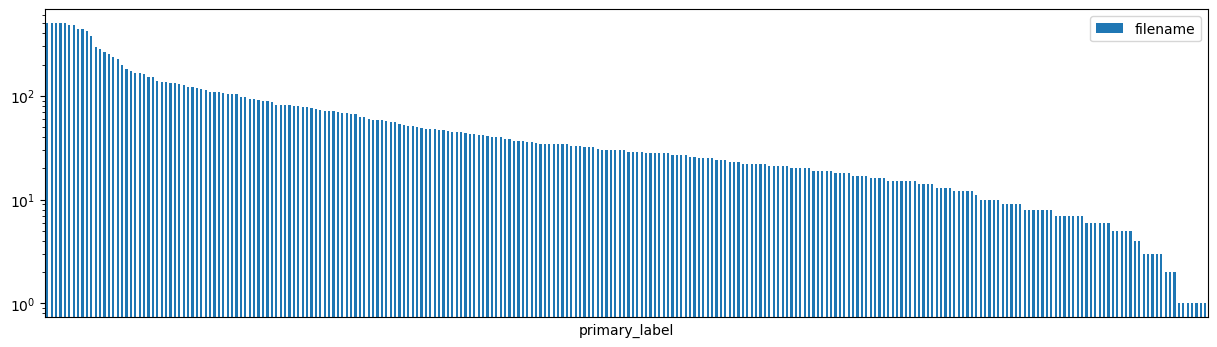

In [15]:
_ = trn_df.pivot_table(index='primary_label', values='filename', aggfunc='count', dropna=False).sort_values('filename', ascending=False).plot.bar(logy=True, xticks=[], figsize=(15,4))

Many species have 10 or fewer labels!

In [16]:
primary_test = trn_df.primary_label.value_counts()
primary_test

barswa     500
wlwwar     500
thrnig1    500
eaywag1    500
comsan     500
          ... 
lotcor1      1
whctur2      1
whhsaw1      1
afpkin1      1
crefra2      1
Name: primary_label, Length: 264, dtype: int64

### Secondary Labels

There are more secondary labels than primary labels. That should mean there are sounds of birds we do not need to predict.

In [17]:
len(set(itertools.chain.from_iterable(trn_df.secondary_labels)))

195

In [18]:
trn_df.secondary_labels.value_counts(dropna=False)

[]                                      14636
[combul2]                                 169
[somgre1]                                  76
[rindov]                                   74
[wlwwar]                                   64
                                        ...  
[klacuc1, laudov1]                          1
[carcha1, hadibi1, helgui]                  1
[grbcam1, gyhspa1, laudov1]                 1
[carcha1, reftin1]                          1
[grbcam1, gryapa1, ndcsun2, yertin1]        1
Name: secondary_labels, Length: 751, dtype: int64

If we were to start by looking only at clips without secondary labels, what would our coverage of the species be?

Should we consider  boosting training data using the secondary labels? 

In [19]:
sec_ss = to_1D(trn_df.secondary_labels).value_counts()
sec_ss.index.rename('species', inplace=True)
sec_ss.name = 'secondary_label'
sec_ss

species
combul2    349
rindov     200
somgre1    152
grbcam1    130
laudov1    100
          ... 
afpkin1      1
loceag1      1
gyhneg1      1
darter3      1
refbar2      1
Name: secondary_label, Length: 195, dtype: int64

Any species for which we have few primary labels but more plentiful secondary labels?

In [20]:
prim_ss = trn_df.groupby('primary_label')['primary_label'].count()
prim_ss.index.rename('species', inplace=True)
prim_ss

species
abethr1     15
abhori1    126
abythr1     28
afbfly1     18
afdfly1     31
          ... 
yertin1    134
yesbar1     29
yespet1     15
yetgre1     27
yewgre1    108
Name: primary_label, Length: 264, dtype: int64

In [21]:
primsec_df = pd.concat([prim_ss, sec_ss], axis=1)
primsec_df.sort_values(by='primary_label', ascending=True)[:30]

,primary_label,secondary_label
species,,
yebsto1,1,NaN
crefra2,1,NaN
lotcor1,1,1.0
whctur2,1,6.0
afpkin1,1,1.0
whhsaw1,1,NaN
brtcha1,1,NaN
golher1,2,NaN
rehblu1,2,NaN


Might benefit a few species there.

In [20]:
# len(temp_df.primary_label.unique())

In [21]:
# _ = temp_df.pivot_table(index='primary_label', values='filename', aggfunc='count', dropna=False).sort_values('filename', ascending=False).plot.bar(logy=True, xticks=[], figsize=(15,4))

### Type
There is a lot here. We will ignore it for now, but should try to use this information later on.

Some ideas:
  1. Train with more classes, e.g., species-call_type, and then  collapse to species after inference
  2. Pick top fiew and map to channels. E.g., song -> channel 1, call -> channel 2, flight call -> channel 3. Null to all 3?

In [22]:
len(set(itertools.chain.from_iterable(trn_df.type)))

399

In [24]:
trn_df.type.value_counts(dropna=False)[:20]

[song]                                         4102
[call]                                         3987
[]                                             1776
[flight call]                                  1139
[call, song]                                    527
[male, song]                                    359
[call, flight call]                             328
[adult, call, sex uncertain]                    289
[alarm call]                                    281
[adult, sex uncertain, song]                    273
[nocturnal flight call]                         239
[adult, male, song]                             234
[adult, call]                                   174
[call, male]                                    112
[adult, call, male]                             112
[adult, song]                                   110
[call, juvenile]                                 85
[begging call, juvenile]                         77
[female, male, song]                             67
[call, life 

In [25]:
# https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
to_1D(trn_df.type).value_counts()[0:10]

call                     6808
song                     6411
flight call              2235
adult                    1880
                         1785
male                     1433
sex uncertain            1213
alarm call                643
female                    464
nocturnal flight call     418
dtype: int64

### Rating

May want to filter or weight training data using the ratings

In [36]:
sorted(trn_df.rating.unique())

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

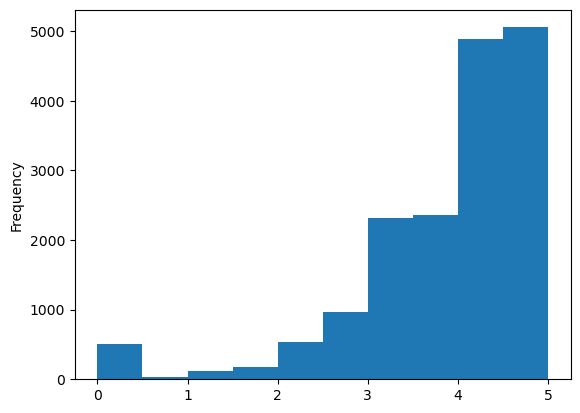

In [25]:
_ = trn_df.rating.plot.hist()

## Extract Audio Metadata

Mostly for learning, but also to look at the distribution of audio file lengths. We're told the sample rates are consistent, but it is worth knowning how to check for future projects.

Bits per sample is zero. I assume this is because the audio has been encoded with a variable bitrate. 

In [26]:
md = torchaudio.info(trn_path/trn_df.filename[0])
print(md)

AudioMetaData(sample_rate=32000, num_frames=1459513, num_channels=1, bits_per_sample=0, encoding=VORBIS)


In [27]:
audio_metadata_df = get_audio_files_metadata(trn_df.filename, parent=trn_path)
audio_metadata_df.to_csv('audio_metadata.csv')

Extracting audio metadata:   0%|          | 0/16941 [00:00<?, ?it/s]

In [28]:
audio_metadata_df

,sample_rate,num_frames,num_channels,bits_per_sample,encoding,seconds
filename,,,,,,
abethr1/XC128013.ogg,32000,1459513,1,0,VORBIS,45.609781
abethr1/XC363501.ogg,32000,597682,1,0,VORBIS,18.677563
abethr1/XC363502.ogg,32000,1240503,1,0,VORBIS,38.765719
abethr1/XC363503.ogg,32000,936229,1,0,VORBIS,29.257156
abethr1/XC363504.ogg,32000,1355024,1,0,VORBIS,42.344500
...,...,...,...,...,...,...
yewgre1/XC703472.ogg,32000,669571,1,0,VORBIS,20.924094
yewgre1/XC703485.ogg,32000,694648,1,0,VORBIS,21.707750
yewgre1/XC704433.ogg,32000,2588003,1,0,VORBIS,80.875094


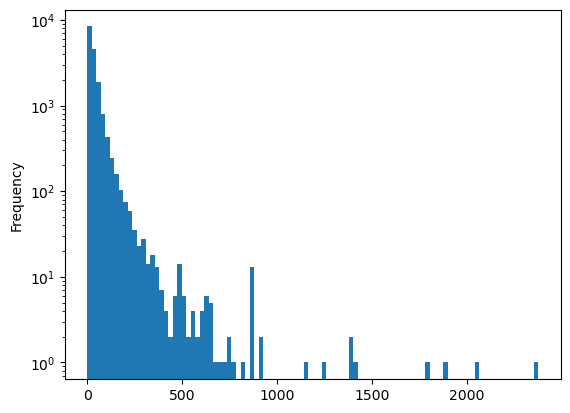

In [29]:
_ = audio_metadata_df.seconds.plot.hist(logy=True, bins=100)

In [30]:
audio_metadata_df.describe()

,sample_rate,num_frames,num_channels,bits_per_sample,seconds
count,16941.0,1.694100e+04,16941.0,16941.0,16941.000000
mean,32000.0,1.308338e+06,1.0,0.0,40.885565
std,0.0,2.227529e+06,0.0,0.0,69.610286
min,32000.0,1.753600e+04,1.0,0.0,0.548000
25%,32000.0,4.087640e+05,1.0,0.0,12.773875
50%,32000.0,7.879680e+05,1.0,0.0,24.624000
75%,32000.0,1.467873e+06,1.0,0.0,45.871031
max,32000.0,7.595290e+07,1.0,0.0,2373.528000


In [31]:
audio_metadata_df.encoding.unique()

array(['VORBIS'], dtype=object)

# Audio Preprocess Experimentation

In [32]:
prep_path = comp_path/'train_audio_prep'
prep_path.mkdir(exist_ok=True)

## Test Case

In [33]:
cfg = AudioConfig.BasicSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
cfg

BasicSpectrogram(n_fft=400, win_length=None, hop_length=None, pad=0, window_fn=<built-in method hann_window of type object at 0x7fa3f1f5f540>, power=2.0, normalized=False, wkwargs=None, center=True, pad_mode='reflect', onesided=True, return_complex=None, mel=False, to_db=True)

### Original

birdclef-2023/train_audio/somgre1/XC446893.ogg


TypeError: waveshow() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given

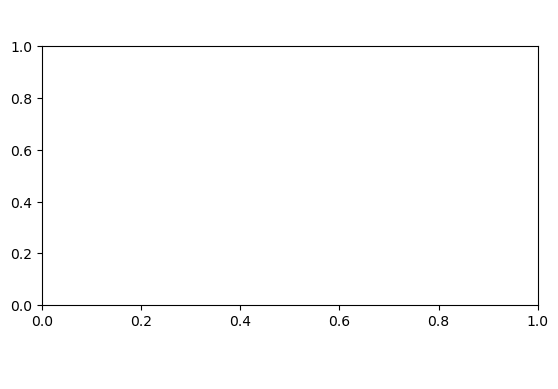

In [34]:
print(ogg_files[0])
pipe = Pipeline([aud2spec])
audio = AudioTensor.create(ogg_files[0])
audio.show()
pipe(audio).show()

### Preprocessed

In [ ]:
rmsilence = RemoveSilence(remove_type=RemoveType.All, threshold=30)
resample = Resample(sr_new=16000)
resize = ResizeSignal(duration=10e3)
pipe_prep_1 = Pipeline([resample, rmsilence, resize])
pipe_prep_2 = Pipeline([resample, rmsilence, resize, aud2spec])

In [ ]:
audio_prep = AudioTensor.create(ogg_files[0])
pipe_prep_1(audio_prep).show()
pipe_prep_2(audio_prep).show()

# References

* [fastaudio]: Coultas Blum, Harry A, Lucas G. Scart, and Robert Bracco. 2020. “Fastaudio.” *GitHub*. <https://github.com/fastaudio/fastaudio>.
* [torchaudio]: TorchAudio. <https://pytorch.org/audio/stable/feature_classifications.html>
* https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173 for dealing with lists in pandas columns

# Further Exploration

* Use more of fastkaggle https://fastai.github.io/fastkaggle/
* FastAudio: https://colab.research.google.com/github/fastaudio/fastaudio/blob/master/docs/ESC50:%20Environmental%20Sound%20Classification.ipynb#scrollTo=6T8g4m4h3hNq

* One challenge with the dataset here is we have training audio of varying length with lots of quiet periods between bird calls. When we divide up a training audio signal, some pieces will not have bird calls and we don't want to assign the label(s) of the entire file to each piece. We could try multiple instance learning to deal with this. 

* Training audio with multiple labels may further complicate training. Can we start with multiple instance learning using only the training sets with single labels and then use that model to divide our multiple instances into groups with different labels for further training?

* Try TorchAudio pre-trained models as a backbone

* One-hot-encode extras? https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list